# 뉴스기사의 카테고리 판정하기

## TF-IDF 모듈 만들기

tfidf.py

In [ ]:
# TF-IDF로 텍스트를 벡터로 변환하는 모듈
from konlpy.tag import Okt
import pickle
import numpy as np

# KoNLPy의 Okt객체 초기화
okt = Okt()
# 전역 변수 
word_dic = {'_id': 0} # 단어 사전
dt_dic = {} # 문장 전체에서의 단어 출현 횟수
files = [] # 문서들을 저장할 리스트

def tokenize(text):
    '''KoNLPy로 형태소 분석하기''' 
    result = []
    word_s = okt.pos(text, norm=True, stem=True)
    for n, h in word_s:
        if not (h in ['Noun', 'Verb ', 'Adjective']): continue
        if h == 'Punctuation' and h2 == 'Number': continue
        result.append(n)
    return result

def words_to_ids(words, auto_add = True):
    ''' 단어를 ID로 변환하기 ''' 
    result = []
    for w in words:
        if w in word_dic:
            result.append(word_dic[w])
            continue
        elif auto_add:
            id = word_dic[w] = word_dic['_id']
            word_dic['_id'] += 1
            result.append(id)
    return result

def add_text(text):
    '''텍스트를 ID 리스트로 변환해서 추가하기''' 
    ids = words_to_ids(tokenize(text))
    files.append(ids)

def add_file(path):
    '''텍스트 파일을 학습 전용으로 추가하기''' 
    with open(path, "r", encoding="utf-8") as f:
        s = f.read()
        add_text(s)

def calc_files():
    '''추가한 파일 계산하기''' 
    global dt_dic
    result = []
    doc_count = len(files)
    dt_dic = {}
    # 단어 출현 횟수 세기 
    for words in files:
        used_word = {}
        data = np.zeros(word_dic['_id'])
        for id in words:
            data[id] += 1
            used_word[id] = 1
        # 단어 t가 사용되고 있을 경우 dt_dic의 수를 1 더하기
        for id in used_word:
            if not(id in dt_dic): dt_dic[id] = 0
            dt_dic[id] += 1
        # 정규화하기 
        data = data / len(words) 
        result.append(data)
    # TF-IDF 계산하기 
    for i, doc in enumerate(result):
        for id, v in enumerate(doc):
            idf = np.log(doc_count / dt_dic[id]) + 1
            doc[id] = min([doc[id] * idf, 1.0])
        result[i] = doc
    return result

def save_dic(fname):
    '''사전을 파일로 저장하기''' 
    pickle.dump(
        [word_dic, dt_dic, files],
        open(fname, "wb"))

def load_dic(fname):
    '''사전 파일 읽어 들이기''' 
    global word_dic, dt_dic, files
    n = pickle.load(open(fname, 'rb'))
    word_dic, dt_dic, files = n

def calc_text(text):
    ''' 문장을 벡터로 변환하기 ''' 
    data = np.zeros(word_dic['_id'])
    words = words_to_ids(tokenize(text), False)
    for w in words:
        data[w] += 1
    data = data / len(words)
    for id, v in enumerate(data):
        idf = np.log(len(files) / dt_dic[id]) + 1
        data[id] = min([data[id] * idf, 1.0])
    return data
# 모듈 테스트하기 
if __name__ == '__main__':
    add_text('비')
    add_text('오늘은 비가 내렸어요.') 
    add_text('오늘은 더웠지만 오후부터 비가 내렸다.') 
    add_text('비가 내리는 일요일이다.') 
    print(calc_files())
    print(word_dic)

## 텍스트 분류하기

makedb_tfid.py

In [ ]:
import os, glob, pickle
import tfidf

# 변수 초기화
y = []
x = []

# 디렉터리 내부의 파일 목록 전체에 대해 처리하기
def read_files(path, label):
    print("read_files=", path)
    files = glob.glob(path + "/*.txt")
    for f in files:
        if os.path.basename(f) == 'LICENSE.txt': continue
        tfidf.add_file(f)
        y.append(label)

# 기사를 넣은 디렉터리 읽어 들이기
read_files('text/100', 0)
read_files('text/101', 1)
read_files('text/103', 2)
read_files('text/105', 3)


# TF-IDF 벡터로 변환하기
x = tfidf.calc_files()

# 저장하기
pickle.dump([y, x], open('text/genre.pickle', 'wb'))
tfidf.save_dic('text/genre-tdidf.dic')
print('ok')


## TF-IDF를 나이브 베이즈로 학습시키기

In [16]:
import pickle
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import numpy as np

# TF-IDF 데이터베이스 읽어 들이기 
data = pickle.load(open("text/genre.pickle", "rb"))
y = data[0] # 레이블
x = data[1] # TF-IDF

# 학습 전용과 테스트 전용으로 구분하기
x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2)

# 나이브 베이즈로 학습하기
model = GaussianNB()
model.fit(x_train, y_train)

# 평가하고 결과 출력하기
y_pred = model.predict(x_test)
acc = metrics.accuracy_score(y_test, y_pred)
rep = metrics.classification_report(y_test, y_pred)

print("정답률=", acc)
print(rep)

정답률= 0.8390625
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       170
           1       0.87      0.68      0.76       146
           2       0.76      0.90      0.82       172
           3       0.82      0.85      0.83       152

    accuracy                           0.84       640
   macro avg       0.85      0.83      0.84       640
weighted avg       0.85      0.84      0.84       640



## 딥러닝으로 정답률 개선하기

Train on 2557 samples, validate on 640 samples
Epoch 1/20
2557/2557 [==============================] - 8s 3ms/step - loss: 0.8509 - acc: 0.7478 - val_loss: 0.3926 - val_acc: 0.8844
Epoch 2/20
2557/2557 [==============================] - 7s 3ms/step - loss: 0.2494 - acc: 0.9222 - val_loss: 0.3113 - val_acc: 0.8891
Epoch 3/20
2557/2557 [==============================] - 7s 3ms/step - loss: 0.1091 - acc: 0.9664 - val_loss: 0.2812 - val_acc: 0.8969
Epoch 4/20
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0462 - acc: 0.9894 - val_loss: 0.2955 - val_acc: 0.9031
Epoch 5/20
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0223 - acc: 0.9934 - val_loss: 0.3363 - val_acc: 0.8969
Epoch 6/20
2557/2557 [==============================] - 7s 3ms/step - loss: 0.0114 - acc: 0.9977 - val_loss: 0.3783 - val_acc: 0.8906
Epoch 7/20
2557/2557 [==============================] - 8s 3ms/step - loss: 0.0071 - acc: 0.9973 - val_loss: 0.3728 - val_acc: 0.9016
Epoch 8/20
2557

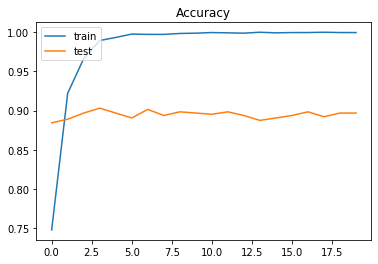

In [18]:
import pickle
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
import h5py

# 분류할 레이블 수
nb_classes = 4

# 데이터베이스 읽어 들이기 
data = pickle.load(open("text/genre.pickle", "rb"))
y = data[0] # 레이블
x = data[1] # TF-IDF
# 레이블 데이터를 One-hot 형식으로 변환하기
y = keras.utils.np_utils.to_categorical(y, nb_classes)
in_size = x[0].shape[0]

# 학습 전용과 테스트 전용으로 구분하기 
x_train, x_test, y_train, y_test = train_test_split(
        np.array(x), np.array(y), test_size=0.2)

# MLP모델의 구조 정의하기
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(in_size,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes, activation='softmax'))

# 모델 컴파일하기 
model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'])

# 학습 실행하기 
hist = model.fit(x_train, y_train,
          batch_size=128, 
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test))

# 평가하기 
score = model.evaluate(x_test, y_test, verbose=1)
print("정답률=", score[1], 'loss=', score[0])

# 가중치데이터 저장하기
model.save_weights('./text/genre-model.hdf5')

# 학습 상태를 그래프로 그리기 
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 직접 문장을 지정해 판정하기

my_text.py

In [ ]:
import pickle, tfidf
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.models import model_from_json

# 텍스트 준비하기
text1 = """
대통령이 북한과 관련된 이야기로 한미 정상회담을 준비하고 있습니다.
"""
text2 = """
iPhone과 iPad를 모두 가지고 다니므로 USB를 2개 연결할 수 있는 휴대용 배터리를 선호합니다.
"""
text3 = """
이번 주에는 미세먼지가 많을 것으로 예상되므로 노약자는 외출을 자제하는 것이 좋습니다.
"""

# TF-IDF 사전 읽어 들이기
tfidf.load_dic("text/genre-tdidf.dic")

# Keras 모델 정의하고 가중치 데이터 읽어 들이기
nb_classes = 4
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(52800,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'])
model.load_weights('./text/genre-model.hdf5')

# 텍스트 지정해서 판별하기 
def check_genre(text):
    # 레이블 정의하기
    LABELS = ["정치", "경제", "생활 ", "IT/과학"]
    # TF-IDF 벡터로 변환하기 
    data = tfidf.calc_text(text)
    # MLP로 예측하기 
    pre = model.predict(np.array([data]))[0]
    n = pre.argmax()
    print(LABELS[n], "(", pre[n], ")")
    return LABELS[n], float(pre[n]), int(n) 

if __name__ == '__main__':
    check_genre(text1)
    check_genre(text2)
    check_genre(text3)